# Ecommerce customer data prediction - Linear Regression

Here we examine a dataset with Ecommerce Customer Data for a company's website and mobile app. The task is to predict the customer's yearly spend on the company's product using a regression model.

In [6]:
import findspark
findspark.init('/home/matt/spark-3.1.1-bin-hadoop2.7')

In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ecommerce').getOrCreate()

In [8]:
from pyspark.ml.regression import LinearRegression

In [9]:
# read in the Ecommerce Customers csv file.
data = spark.read.csv("Ecommerce_Customers.csv",inferSchema=True,header=True)

In [10]:
# Print the Schema of the DataFrame
data.printSchema()

root
 |-- Email: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Avatar: string (nullable = true)
 |-- Avg Session Length: double (nullable = true)
 |-- Time on App: double (nullable = true)
 |-- Time on Website: double (nullable = true)
 |-- Length of Membership: double (nullable = true)
 |-- Yearly Amount Spent: double (nullable = true)



In [11]:
data.head()

Row(Email='mstephenson@fernandez.com', Address='835 Frank TunnelWrightmouth, MI 82180-9605', Avatar='Violet', Avg Session Length=34.49726772511229, Time on App=12.65565114916675, Time on Website=39.57766801952616, Length of Membership=4.0826206329529615, Yearly Amount Spent=587.9510539684005)

In [12]:
# display details of first data point
for item in data.head():
    print(item)

mstephenson@fernandez.com
835 Frank TunnelWrightmouth, MI 82180-9605
Violet
34.49726772511229
12.65565114916675
39.57766801952616
4.0826206329529615
587.9510539684005


## Feature Vectors and Labels

In [13]:
# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [14]:
data.columns

['Email',
 'Address',
 'Avatar',
 'Avg Session Length',
 'Time on App',
 'Time on Website',
 'Length of Membership',
 'Yearly Amount Spent']

In [15]:
# assemble specific columns as features to use - ignore irrelevant columns
assembler = VectorAssembler(
    inputCols=["Avg Session Length", "Time on App", 
               "Time on Website",'Length of Membership'],
    outputCol="features")

In [16]:
output = assembler.transform(data)

In [28]:
output.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|[34.4972677251122...|
|[31.9262720263601...|
|[33.0009147556426...|
|[34.3055566297555...|
|[33.3306725236463...|
+--------------------+
only showing top 5 rows



In [18]:
# select features and labels (to be predicted) to use in the model
final_data = output.select("features",'Yearly Amount Spent')

In [19]:
# split data into train/test
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [20]:
train_data.describe().show()

+-------+-------------------+
|summary|Yearly Amount Spent|
+-------+-------------------+
|  count|                351|
|   mean|  499.7942727150914|
| stddev|  82.14218128208528|
|    min| 256.67058229005585|
|    max|  765.5184619388373|
+-------+-------------------+



In [21]:
test_data.describe().show()

+-------+-------------------+
|summary|Yearly Amount Spent|
+-------+-------------------+
|  count|                149|
|   mean| 498.18274769327735|
| stddev|  72.47024217758194|
|    min|   266.086340948469|
|    max|  708.9351848669818|
+-------+-------------------+



## Train model

In [22]:
# Create a Linear Regression Model object and assign labels
lr = LinearRegression(labelCol='Yearly Amount Spent')

In [23]:
# Fit the model to the data and call this model lrModel
lrModel = lr.fit(train_data,)

In [24]:
# Print the coefficients and intercept for linear regression
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

Coefficients: [25.231921784383758,38.701017001264454,0.6388297241182934,61.685486469000494] Intercept: -1043.0208920588236


## Evaluate model

In [30]:
# evaluate on test set
test_results = lrModel.evaluate(test_data)

In [31]:
# Highlight residuals
test_results.residuals.show(5)

+-------------------+
|          residuals|
+-------------------+
|-17.597902793099706|
| -6.770043912860558|
|-1.3305777117542448|
| -4.156743793636224|
| -8.543966345523245|
+-------------------+
only showing top 5 rows



In [48]:
# evaluate rmse & mse of the trained model 
train_results = lrModel.evaluate(train_data)
print("RMSE: {}".format(train_results.rootMeanSquaredError))
print("MSE: {}".format(train_results.meanSquaredError))

RMSE: 10.043061573210789
MSE: 100.86308576330318


In [33]:
#print performance metrics of test data
print("RMSE: {}".format(test_results.rootMeanSquaredError))
print("MSE: {}".format(test_results.meanSquaredError))

RMSE: 9.698600901441138
MSE: 94.06285944543484


## Plot results

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

In [43]:
test_results.predictions.show(5)

+--------------------+-------------------+------------------+
|            features|Yearly Amount Spent|        prediction|
+--------------------+-------------------+------------------+
|[30.8162006488763...|   266.086340948469| 283.6842437415687|
|[31.0613251567161...|  487.5554580579016|494.32550197076216|
|[31.2606468698795...|  421.3266312569514| 422.6572089687056|
|[31.2681042107507...|  423.4705331738239|427.62727696746015|
|[31.4474464941278...|   418.602742095224|427.14670844074726|
+--------------------+-------------------+------------------+
only showing top 5 rows



<AxesSubplot:xlabel='Yearly Amount Spent', ylabel='prediction'>

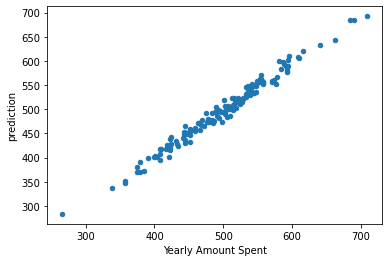

In [45]:
# convert data to pandas dataframe
pl = test_results.predictions.select('Yearly Amount Spent','prediction').toPandas()

## versus
pl.plot.scatter(x='Yearly Amount Spent',y='prediction')

<AxesSubplot:>

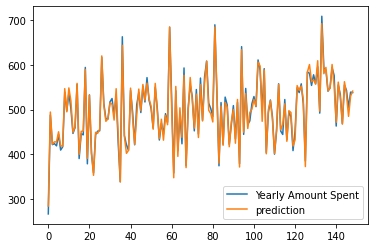

In [46]:
## difference
pl.plot()